In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics

In [27]:
def read_csv_file(file_path):
    try:
        return pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        return pd.read_csv(file_path, encoding='latin1')


def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

def Encoding(df):
    # Create the ncoder variable
    encoder = LabelEncoder()
    cat_df = df.select_dtypes(include=['object'])
    for i in cat_df:
        # fit the categoral feature to the encoding method
        df[i] = encoder.fit_transform(df[i]) 
    return df

def MissingValueHandling(merged_df):
    null_col =  dict(merged_df.isnull().sum()) 
    missing_data = []
    for key, value in null_col.items():
        if (value != 0):
            missing_data.append(key) 
    print("Missing Values Column:", null_col)
    for i in missing_data:
        fill_list = merged_df[i].dropna().tolist()
        merged_df[i] = merged_df[i].fillna(pd.Series(np.random.choice(fill_list , size = len(merged_df.index))))
    return merged_df
    
# Function to train and evaluate models
def train_and_evaluate(model, model_name, X_train_scaled, y_train, X_test_scaled, y_test):
    model.fit(X_train_scaled, y_train)
    train_accuracy = model.score(X_train_scaled, y_train) * 100
    test_accuracy = model.score(X_test_scaled, y_test) * 100
    # y_pred = model.predict(X_test_scaled)
    # accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{model_name} Training Accuracy: {train_accuracy:.2f}")
    print(f"{model_name} Testing Accuracy: {test_accuracy:.2f}")
    # print(f"{model_name} Model Accuracy: {accuracy:.2f}")
    print('-' * 50)


def evaluate_classification_model(model, X_test, y_test):
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # Print the evaluation metrics
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    # Plot the confusion matrix
    labels = np.unique(y_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot the confusion matrix:
def cmatrix_fun(model_name, actual, predicted):
    # Compute confusion matrix
    cm = metrics.confusion_matrix(actual, predicted)
    
    # Normalize confusion matrix
    cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot the normalized confusion matrix
    class_labels = ['normal', 'mild', 'moderate', 'severe']
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels = class_labels)
    cm_display.plot(ax=ax, cmap='Blues')
    
    # Set axis labels
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix of', model_name)
    plt.show()

In [28]:
import random
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)

In [29]:
womac_path = "csv/data_training/Aparameters.csv"
features_path = "csv/data_training/AllFeatures.csv"

wdf = read_csv_file(womac_path)
fdf = read_csv_file(features_path)

fdf.columns = fdf.columns.str.strip()
wdf.columns = wdf.columns.str.strip()

assert 'patient_id' in fdf.columns, "'patient_id' not found in fdf columns"
assert 'patient_id' in wdf.columns, "'patient_id' not found in wdf columns"

fdf.head()
# wdf.head()

,patient_id,swing_time_max,swing_time_min,stance_time_max,stance_time_min,stride_time_max,stride_time_min,strike_angle,mean_hs_angle,mean_to_angle,...,powerY_ 3_C,powerY_ 4_C,powerY_ 5_C,powerY_ 6_C,powerZ_ 1_C,powerZ_ 2_C,powerZ_ 3_C,powerZ_ 4_C,powerZ_ 5_C,powerZ_ 6_C
0,1,1.04,0.46,1.18,0.81,1.99,1.31,24.491429,24.000000,38.840000,...,1040.211971,73.481629,141.905164,10.216969,1.571939e+06,607.747259,533.161447,2633.837158,3055.918834,173.842186
1,1,1.22,0.42,1.39,0.08,2.24,0.53,21.702500,21.227143,34.982857,...,1964.301772,816.673624,404.261715,228.916362,2.954191e+06,109.416956,2606.851615,10.729508,5185.243035,25.271313
2,1,1.01,0.42,1.01,0.23,2.02,0.65,18.201429,17.451667,32.843333,...,4199.071301,3488.940407,113.009892,760.522046,1.902485e+06,860.193745,304.164403,12119.034787,1532.932283,537.452090
3,10,0.90,0.43,0.85,0.52,1.61,1.00,12.638571,11.700000,27.365000,...,753.474303,535.838457,105.252777,182.907451,9.738762e+05,2350.306948,2954.338341,2614.545432,1978.834077,105.690189
4,10,0.61,0.36,0.86,0.34,1.43,0.95,16.573750,17.008571,28.935714,...,442.169719,431.027909,176.619568,75.768927,1.519685e+06,72.975955,462.167270,1289.025156,711.321877,26.048736


# Preprocessing

## Merging two Dataframes

In [30]:
# Get the count of trials per patient
trials_counts = fdf['patient_id'].value_counts().to_dict()
print("trials:", trials_counts)
# Expand the anthropometric data
expanded_wdf = wdf.loc[
    wdf.index.repeat(wdf['patient_id'].map(trials_counts))
].reset_index(drop=True)
print("features df shape:", fdf.shape)
print("all df shape:", expanded_wdf.shape)

trials: {11: 5, 17: 4, 18: 4, 23: 4, 22: 4, 21: 4, 20: 4, 7: 4, 8: 4, 6: 4, 16: 4, 15: 4, 14: 4, 13: 4, 12: 4, 5: 3, 1: 3, 2: 3, 3: 3, 10: 3, 19: 3, 9: 3, 4: 2}
features df shape: (84, 56)
all df shape: (84, 7)


In [31]:
merged_df = pd.merge(fdf, wdf, on='patient_id', how='left')
merged_df

,patient_id,swing_time_max,swing_time_min,stance_time_max,stance_time_min,stride_time_max,stride_time_min,strike_angle,mean_hs_angle,mean_to_angle,...,powerZ_ 3_C,powerZ_ 4_C,powerZ_ 5_C,powerZ_ 6_C,name,gender,leg,age,BMI,severity
0,1,1.04,0.46,1.18,0.81,1.99,1.31,24.491429,24.000000,38.840000,...,533.161447,2633.837158,3055.918834,173.842186,marwa abdelaly,f,right,40.0,35.755956,mild
1,1,1.22,0.42,1.39,0.08,2.24,0.53,21.702500,21.227143,34.982857,...,2606.851615,10.729508,5185.243035,25.271313,marwa abdelaly,f,right,40.0,35.755956,mild
2,1,1.01,0.42,1.01,0.23,2.02,0.65,18.201429,17.451667,32.843333,...,304.164403,12119.034787,1532.932283,537.452090,marwa abdelaly,f,right,40.0,35.755956,mild
3,10,0.90,0.43,0.85,0.52,1.61,1.00,12.638571,11.700000,27.365000,...,2954.338341,2614.545432,1978.834077,105.690189,rehab helmy,m,right,35.0,29.136316,mild
4,10,0.61,0.36,0.86,0.34,1.43,0.95,16.573750,17.008571,28.935714,...,462.167270,1289.025156,711.321877,26.048736,rehab helmy,m,right,35.0,29.136316,mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,8,0.70,0.47,1.15,0.82,1.85,1.31,17.150000,16.812000,25.746000,...,1520.306683,1620.084514,810.152477,98.917555,sameh mostafa,m,right,43.0,41.207561,normal
80,8,2.39,0.52,1.38,0.59,2.98,1.36,25.272857,18.786667,22.300000,...,45.824601,1505.276923,991.774908,18.398063,sameh mostafa,m,right,43.0,41.207561,normal
81,9,1.35,0.49,1.23,0.57,2.19,1.27,25.482727,24.932000,20.004000,...,2444.744831,38.121232,1453.824808,100.249514,samia abd-allah,f,left,NaN,28.133657,severe
82,9,1.19,0.38,1.25,0.59,1.78,1.09,20.538571,22.143333,18.550000,...,681.342965,385.500887,252.893451,112.816790,samia abd-allah,f,left,NaN,28.133657,severe


In [32]:
# merged_df.to_csv("csv/data_training/final_data.csv", index=False)

In [33]:
merged_df.shape

(84, 62)

In [34]:
np.mean(merged_df["BMI"])

30.15808152613778

In [35]:
mean_bmi_by_severity = merged_df.groupby('severity')['BMI'].mean()
mean_bmi_by_severity

severity
mild        31.328903
moderate    29.577369
normal      28.952814
severe      30.076248
Name: BMI, dtype: float64

In [36]:
merged_df.groupby('severity')['BMI'].apply(lambda x: x.mode())

severity   
mild      0    32.466181
moderate  0    25.816630
          1    26.037494
normal    0    17.577069
          1    26.124567
          2    26.222222
          3    33.632653
          4    41.207561
severe    0    27.767098
          1    29.068796
          2    33.057851
Name: BMI, dtype: float64

### Missing data handling

In [37]:
merged_df = MissingValueHandling(merged_df)
    
null_col =  np.array(merged_df.isnull().sum()) 
print("Missing values:", null_col)

Missing Values Column: {'patient_id': 0, 'swing_time_max': 0, 'swing_time_min': 0, 'stance_time_max': 0, 'stance_time_min': 0, 'stride_time_max': 0, 'stride_time_min': 0, 'strike_angle': 0, 'mean_hs_angle': 0, 'mean_to_angle': 0, 'thrustACCel_C': 7, 'thrustACCel_T': 16, 'max_stance_angles': 3, 'max_swing_angles': 0, 'Omega_X_T': 0, 'Omega_Y_T': 0, 'Omega_Z_T': 0, 'powerX_ 1_T': 0, 'powerX_ 2_T': 0, 'powerX_ 3_T': 0, 'powerX_ 4_T': 0, 'powerX_ 5_T': 0, 'powerX_ 6_T': 0, 'powerY_ 1_T': 0, 'powerY_ 2_T': 0, 'powerY_ 3_T': 0, 'powerY_ 4_T': 0, 'powerY_ 5_T': 0, 'powerY_ 6_T': 0, 'powerZ_ 1_T': 0, 'powerZ_ 2_T': 0, 'powerZ_ 3_T': 0, 'powerZ_ 4_T': 0, 'powerZ_ 5_T': 0, 'powerZ_ 6_T': 0, 'Omega_X_C': 0, 'Omega_Y_C': 0, 'Omega_Z_C': 0, 'powerX_ 1_C': 0, 'powerX_ 2_C': 0, 'powerX_ 3_C': 0, 'powerX_ 4_C': 0, 'powerX_ 5_C': 0, 'powerX_ 6_C': 0, 'powerY_ 1_C': 0, 'powerY_ 2_T.1': 0, 'powerY_ 3_C': 0, 'powerY_ 4_C': 0, 'powerY_ 5_C': 0, 'powerY_ 6_C': 0, 'powerZ_ 1_C': 0, 'powerZ_ 2_C': 0, 'powerZ_

### Encoding Categorical data

In [38]:
print('Severity before Encoding:')
print(dict(merged_df['severity'].value_counts()))

merged_df = Encoding(merged_df)
    
# # Check that the value transformed successfully 
print('Severity after Encoding:')
dict(merged_df['severity'].value_counts())

Severity before Encoding:
{'mild': 29, 'severe': 21, 'normal': 20, 'moderate': 14}
Severity after Encoding:


{0: 29, 3: 21, 2: 20, 1: 14}

In [39]:
merged_df = shuffle(merged_df, random_state=random_seed)

columns_to_drop = ['patient_id', 'name', 'leg', 'severity']

X = merged_df.drop(columns = columns_to_drop, axis = 1)  
y = merged_df['severity']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train.shape

(67, 58)

## Feature Selection

### Filter Method

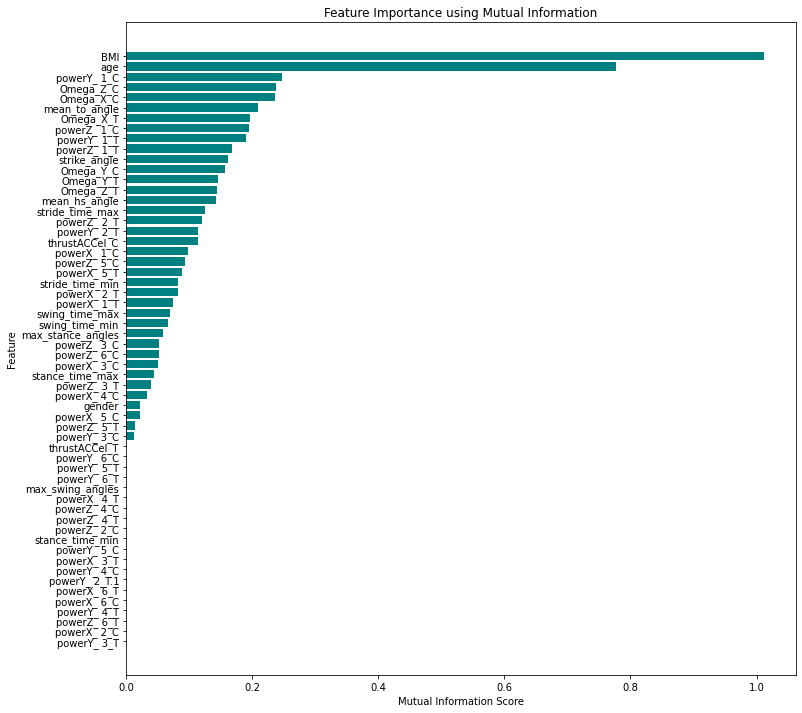

In [40]:
###################################################### Information Gain ######################################################
mi_scores = mutual_info_classif(X, y)
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
# Sort features by their mutual information scores
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False)
# mi_scores_df

# Plot feature importance
plt.figure(figsize=(12, 12))
plt.barh(mi_scores_df['Feature'], mi_scores_df['MI Score'], color='teal')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Feature Importance using Mutual Information')
plt.gca().invert_yaxis()  # To display the highest scores at the top

# Save the plot as an image
# plt.savefig('important_img/Gain_feature_importance.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

In [41]:
non_selected_features = []
for i in range(len(mi_scores_df["Feature"])):
    # print(mi_scores_df["Feature"][i])
    if mi_scores_df["MI Score"][i] == 0.000000:
        non_selected_features.append(mi_scores_df["Feature"][i])

non_selected_features

['stance_time_min',
 'thrustACCel_T',
 'max_swing_angles',
 'powerX_ 3_T',
 'powerX_ 4_T',
 'powerX_ 6_T',
 'powerY_ 3_T',
 'powerY_ 4_T',
 'powerY_ 5_T',
 'powerY_ 6_T',
 'powerZ_ 4_T',
 'powerZ_ 6_T',
 'powerX_ 2_C',
 'powerX_ 6_C',
 'powerY_ 2_T.1',
 'powerY_ 4_C',
 'powerY_ 5_C',
 'powerY_ 6_C',
 'powerZ_ 2_C',
 'powerZ_ 4_C']

### drop the correlated features

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [43]:
# X_train_corr = X_train.drop(corr_features,axis=1)
# X_test_corr = X_test.drop(corr_features,axis=1)
# X_train_corr.columns

### drop selected features from filtering method

In [44]:
X_train_filter = X_train.drop(non_selected_features, axis=1)
X_test_filter = X_test.drop(non_selected_features, axis=1)
X_train_filter.columns

Index(['swing_time_max', 'swing_time_min', 'stance_time_max',
       'stride_time_max', 'stride_time_min', 'strike_angle', 'mean_hs_angle',
       'mean_to_angle', 'thrustACCel_C', 'max_stance_angles', 'Omega_X_T',
       'Omega_Y_T', 'Omega_Z_T', 'powerX_ 1_T', 'powerX_ 2_T', 'powerX_ 5_T',
       'powerY_ 1_T', 'powerY_ 2_T', 'powerZ_ 1_T', 'powerZ_ 2_T',
       'powerZ_ 3_T', 'powerZ_ 5_T', 'Omega_X_C', 'Omega_Y_C', 'Omega_Z_C',
       'powerX_ 1_C', 'powerX_ 3_C', 'powerX_ 4_C', 'powerX_ 5_C',
       'powerY_ 1_C', 'powerY_ 3_C', 'powerZ_ 1_C', 'powerZ_ 3_C',
       'powerZ_ 5_C', 'powerZ_ 6_C', 'gender', 'age', 'BMI'],
      dtype='object')

## Scaling the data

In [45]:
# # Initialize StandardScaler
# scaler_corr = StandardScaler()
# X_train_corr = scaler_corr.fit_transform(X_train_corr)
# X_test_corr = scaler_corr.transform(X_test_corr)

In [46]:
scaler_filter = StandardScaler()
X_train_filter = scaler_filter.fit_transform(X_train_filter)
X_test_filter = scaler_filter.transform(X_test_filter)

# Models Training

### Selected feature training

In [47]:
from sklearn.model_selection import GridSearchCV
# Define models and their parameter grids for Grid Search
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5],
    },
    "Logistic Regression": {
        "C": np.logspace(-4, 4, 20),
        "solver": ["lbfgs", "liblinear"],
    },
    "KNN (k=7)": {
        "n_neighbors": [5, 7, 9],
        "weights": ["uniform", "distance"],
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 6, 10],
    },
    "linear SVM": {
        "C": np.logspace(-4, 4, 20),
    },
    "Poly SVM": {
        "C": np.logspace(-4, 4, 20),
        "degree": [2, 3, 4],
    },
    "rbf SVM": {
        "C": np.logspace(-4, 4, 20),
        "gamma": ["scale", "auto"],
    },
    "Sigmoid SVM": {
        "C": np.logspace(-4, 4, 20),
        "gamma": ["scale", "auto"],
    },
    "Lasso Logistic Regression": {
        "C": np.logspace(-4, 4, 20),
    }
}

# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(),
    "KNN (k=7)": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "linear SVM": SVC(kernel='linear', random_state=random_seed),
    "Poly SVM": SVC(kernel='poly', random_state=random_seed),
    "rbf SVM": SVC(kernel='rbf', random_state=random_seed),
    "Sigmoid SVM": SVC(kernel='sigmoid', random_state=random_seed),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=10000, random_state=random_seed)
}

# Train and evaluate each model using Grid Search
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_filter, y_train)
    
    best_model = grid_search.best_estimator_
    train_and_evaluate(best_model, model_name, X_train_filter, y_train, X_test_filter, y_test)
    
# models = {
#     "Random Forest": RandomForestClassifier(random_state=random_seed),
#     "Logistic Regression": LogisticRegression(),
#     "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),
#     "XGBoost": XGBClassifier(),
#     "linear SVM": SVC(kernel='linear', random_state=random_seed),
#     "Poly SVM": SVC(kernel='poly', random_state=random_seed),
#     "rbf SVM": SVC(kernel='rbf', random_state=random_seed),
#     "Sigmoid SVM": SVC(kernel= 'sigmoid', random_state=random_seed),
#     "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=10000, random_state=random_seed)
# }

# # Train and evaluate each model
# for model_name, model in models.items():
#     train_and_evaluate(model, model_name, X_train_filter, y_train, X_test_filter, y_test)


Random Forest Training Accuracy: 100.00
Random Forest Testing Accuracy: 88.24
--------------------------------------------------
Logistic Regression Training Accuracy: 100.00
Logistic Regression Testing Accuracy: 70.59
--------------------------------------------------
KNN (k=7) Training Accuracy: 100.00
KNN (k=7) Testing Accuracy: 70.59
--------------------------------------------------
XGBoost Training Accuracy: 100.00
XGBoost Testing Accuracy: 82.35
--------------------------------------------------
linear SVM Training Accuracy: 98.51
linear SVM Testing Accuracy: 76.47
--------------------------------------------------
Poly SVM Training Accuracy: 100.00
Poly SVM Testing Accuracy: 64.71
--------------------------------------------------
rbf SVM Training Accuracy: 100.00
rbf SVM Testing Accuracy: 82.35
--------------------------------------------------
Sigmoid SVM Training Accuracy: 70.15
Sigmoid SVM Testing Accuracy: 64.71
--------------------------------------------------
Lasso Logi

AttributeError: 'str' object has no attribute 'items'

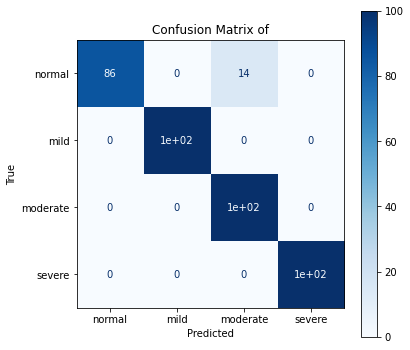

In [48]:
clf = RandomForestClassifier(random_state=random_seed)
clf.fit(X_train_filter, y_train)

y_pred_filter = clf.predict(X_test_filter)

cmatrix_fun("RF with feature selection", y_test, y_pred_filter)

## PCA feature selection and Training

In [49]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components= 30)  # Example: Retain 10 principal components
X_pca = pca.fit_transform(X_scaled)

# X_pca
# principal_X = pd.DataFrame(data = X_pca, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10',
#                                                     'PCA11', 'PCA12', 'PCA13', 'PCA14', 'PCA15', 'PCA16', 'PCA17', 'PCA18', 'PCA19', 'PCA20',
#                                                    'PCA21', 'PCA22', 'PCA23', 'PCA24', 'PCA25', 'PCA26', 'PCA27', 'PCA28', 'PCA29', 'PCA30'])
# finalDf = pd.concat([principal_X, y], axis = 1)
# finalDf


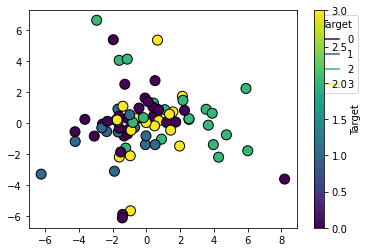

In [50]:
scatter = plt.scatter(X_pca[:, 1], X_pca[:, 3], c=y, cmap='viridis', edgecolor='k', s=100)

# Create a legend with a color for each unique value in y
handles = [plt.Line2D([0,0],[0,0],color=scatter.cmap(scatter.norm(label))) for label in np.unique(y)]
plt.legend(handles, np.unique(y), title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.colorbar(scatter, label='Target')
plt.show()

In [51]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=random_seed)


for model_name, model in models.items():
    train_and_evaluate(model, model_name, X_train_pca, y_train, X_test_pca, y_test)

Random Forest Training Accuracy: 100.00
Random Forest Testing Accuracy: 70.59
--------------------------------------------------
Logistic Regression Training Accuracy: 98.51
Logistic Regression Testing Accuracy: 76.47
--------------------------------------------------
KNN (k=7) Training Accuracy: 53.73
KNN (k=7) Testing Accuracy: 82.35
--------------------------------------------------
XGBoost Training Accuracy: 100.00
XGBoost Testing Accuracy: 76.47
--------------------------------------------------
linear SVM Training Accuracy: 100.00
linear SVM Testing Accuracy: 88.24
--------------------------------------------------
Poly SVM Training Accuracy: 65.67
Poly SVM Testing Accuracy: 11.76
--------------------------------------------------
rbf SVM Training Accuracy: 89.55
rbf SVM Testing Accuracy: 76.47
--------------------------------------------------
Sigmoid SVM Training Accuracy: 62.69
Sigmoid SVM Testing Accuracy: 76.47
--------------------------------------------------
Lasso Logisti

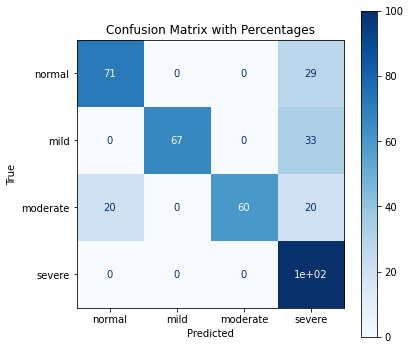

In [52]:
clf = RandomForestClassifier(random_state=random_seed)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

# Compute confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Normalize confusion matrix
cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the normalized confusion matrix
class_labels = ['normal', 'mild', 'moderate', 'severe']
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels = class_labels)
cm_display.plot(ax=ax, cmap='Blues')

# Set axis labels
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix with Percentages')
plt.show()

## No feature selection

In [53]:
X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Initialize StandardScaler
scaler_corr = StandardScaler()
X_train_all = scaler_corr.fit_transform(X_train_all)
X_test_all = scaler_corr.transform(X_test_all)

models = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(),
    "linear SVM": SVC(kernel='linear', random_state=random_seed),
    "Poly SVM": SVC(kernel='poly', random_state=random_seed),
    "rbf SVM": SVC(kernel='rbf', random_state=random_seed),
    "Sigmoid SVM": SVC(kernel= 'sigmoid', random_state=random_seed),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=10000, random_state=random_seed)
}

# Train and evaluate each model
for model_name, model in models.items():
    train_and_evaluate(model, model_name, X_train_all, y_train, X_test_all, y_test)

Random Forest Training Accuracy: 100.00
Random Forest Testing Accuracy: 76.47
--------------------------------------------------
Logistic Regression Training Accuracy: 100.00
Logistic Regression Testing Accuracy: 76.47
--------------------------------------------------
KNN (k=7) Training Accuracy: 58.21
KNN (k=7) Testing Accuracy: 82.35
--------------------------------------------------
XGBoost Training Accuracy: 100.00
XGBoost Testing Accuracy: 88.24
--------------------------------------------------
linear SVM Training Accuracy: 100.00
linear SVM Testing Accuracy: 88.24
--------------------------------------------------
Poly SVM Training Accuracy: 62.69
Poly SVM Testing Accuracy: 17.65
--------------------------------------------------
rbf SVM Training Accuracy: 89.55
rbf SVM Testing Accuracy: 76.47
--------------------------------------------------
Sigmoid SVM Training Accuracy: 70.15
Sigmoid SVM Testing Accuracy: 76.47
--------------------------------------------------
Lasso Logist

# new pca

In [54]:
from sklearn.feature_selection import SelectFromModel


selector = RandomForestClassifier(n_estimators=100)
selector.fit(X_train_all, y_train)  
model = SelectFromModel(selector, prefit=True)
data_selected = model.transform(X_train_all)
pca = PCA(n_components=10)
data_reduced = pca.fit_transform(data_selected)

In [55]:
x1 = model.transform(X_test_all)
x_test = pca.transform(x1)

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import numpy as np

# Define the parameter grids for Grid Search
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5],
    },
    "Logistic Regression": {
        "C": np.logspace(-4, 4, 20),
        "solver": ["lbfgs", "liblinear"],
    },
    "KNN (k=7)": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 6, 10],
    },
    "linear SVM": {
        "C": np.logspace(-4, 4, 20),
    },
    "Poly SVM": {
        "C": np.logspace(-4, 4, 20),
        "degree": [2, 3, 4],
    },
    "rbf SVM": {
        "C": np.logspace(-4, 4, 20),
        "gamma": ["scale", "auto"],
    },
    "Sigmoid SVM": {
        "C": np.logspace(-4, 4, 20),
        "gamma": ["scale", "auto"],
    },
    "Lasso Logistic Regression": {
        "C": np.logspace(-4, 4, 20),
    }
}

# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(),
    "KNN (k=7)": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "linear SVM": SVC(kernel='linear', random_state=random_seed),
    "Poly SVM": SVC(kernel='poly', random_state=random_seed),
    "rbf SVM": SVC(kernel='rbf', random_state=random_seed),
    "Sigmoid SVM": SVC(kernel='sigmoid', random_state=random_seed),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=10000, random_state=random_seed)
}

# Train and evaluate each model using Grid Search
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(data_reduced, y_train)
    
    best_model = grid_search.best_estimator_
    train_and_evaluate(best_model, model_name, data_reduced, y_train, x_test, y_test)


Random Forest Training Accuracy: 100.00
Random Forest Testing Accuracy: 82.35
--------------------------------------------------
Logistic Regression Training Accuracy: 83.58
Logistic Regression Testing Accuracy: 52.94
--------------------------------------------------
KNN (k=7) Training Accuracy: 100.00
KNN (k=7) Testing Accuracy: 100.00
--------------------------------------------------
XGBoost Training Accuracy: 100.00
XGBoost Testing Accuracy: 64.71
--------------------------------------------------
linear SVM Training Accuracy: 80.60
linear SVM Testing Accuracy: 64.71
--------------------------------------------------
Poly SVM Training Accuracy: 100.00
Poly SVM Testing Accuracy: 76.47
--------------------------------------------------
rbf SVM Training Accuracy: 100.00
rbf SVM Testing Accuracy: 76.47
--------------------------------------------------
Sigmoid SVM Training Accuracy: 56.72
Sigmoid SVM Testing Accuracy: 47.06
--------------------------------------------------
Lasso Logi

# Over sampling

In [57]:
from imblearn.over_sampling  import RandomOverSampler
sampling_strategy = {
    0: 2000,
    1: 2000,
    2: 2000,
    3: 2000
    # Add more classes as needed
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Initialize RandomOverSampler with the specified sampling strategy
smoteOver = RandomOverSampler(sampling_strategy=sampling_strategy)
# smoteOver = RandomOverSampler(sampling_strategy=1)
X_smoteOver, y_smoteOver = smoteOver.fit_resample(X_train , y_train)
print(f' X_shape: {X_smoteOver.shape} \n y_shape: {y_smoteOver.shape}')

# Initialize StandardScaler
scaler_corr = StandardScaler()
X_train = scaler_corr.fit_transform(X_smoteOver)
X_test = scaler_corr.transform(X_test)



 X_shape: (8000, 58) 
 y_shape: (8000,)


In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import numpy as np

# Define the parameter grids for Grid Search
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5],
    },
    "Logistic Regression": {
        "C": np.logspace(-4, 4, 20),
        "solver": ["lbfgs", "liblinear"],
    },
    "KNN (k=7)": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 6, 10],
    },
    "linear SVM": {
        "C": np.logspace(-4, 4, 20),
    },
    "Poly SVM": {
        "C": np.logspace(-4, 4, 20),
        "degree": [2, 3, 4],
    },
    "rbf SVM": {
        "C": np.logspace(-4, 4, 20),
        "gamma": ["scale", "auto"],
    },
    "Sigmoid SVM": {
        "C": np.logspace(-4, 4, 20),
        "gamma": ["scale", "auto"],
    },
    "Lasso Logistic Regression": {
        "C": np.logspace(-4, 4, 20),
    }
}

# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(),
    "KNN (k=7)": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "linear SVM": SVC(kernel='linear', random_state=random_seed),
    "Poly SVM": SVC(kernel='poly', random_state=random_seed),
    "rbf SVM": SVC(kernel='rbf', random_state=random_seed),
    "Sigmoid SVM": SVC(kernel='sigmoid', random_state=random_seed),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=10000, random_state=random_seed)
}

# Train and evaluate each model using Grid Search
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_smoteOver)
    
    best_model = grid_search.best_estimator_
    train_and_evaluate(best_model, model_name, X_train, y_smoteOver, X_test, y_test)


Random Forest Training Accuracy: 100.00
Random Forest Testing Accuracy: 94.12
--------------------------------------------------
Logistic Regression Training Accuracy: 100.00
Logistic Regression Testing Accuracy: 82.35
--------------------------------------------------
KNN (k=7) Training Accuracy: 100.00
KNN (k=7) Testing Accuracy: 64.71
--------------------------------------------------
XGBoost Training Accuracy: 100.00
XGBoost Testing Accuracy: 58.82
--------------------------------------------------
linear SVM Training Accuracy: 100.00
linear SVM Testing Accuracy: 76.47
--------------------------------------------------
Poly SVM Training Accuracy: 100.00
Poly SVM Testing Accuracy: 76.47
--------------------------------------------------
rbf SVM Training Accuracy: 100.00
rbf SVM Testing Accuracy: 94.12
--------------------------------------------------
Sigmoid SVM Training Accuracy: 82.39
Sigmoid SVM Testing Accuracy: 58.82
--------------------------------------------------
Lasso Log

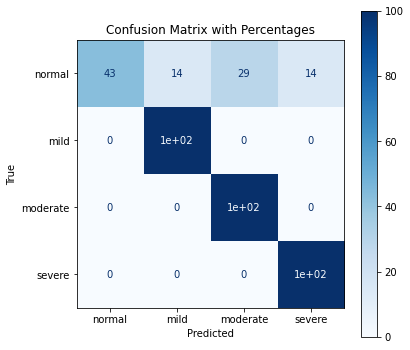

In [63]:
clf =  XGBClassifier()
clf.fit(X_train, y_smoteOver)

y_pred = clf.predict(X_test)

# Compute confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Normalize confusion matrix
cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the normalized confusion matrix
class_labels = ['normal', 'mild', 'moderate', 'severe']
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels = class_labels)
cm_display.plot(ax=ax, cmap='Blues')

# Set axis labels
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix with Percentages')
plt.show()

## Feature Selection using wrapper method

In [64]:
# pip install mlxtend

# from sklearn.feature_selection import SequentialFeatureSelector

# estimator = LogisticRegression(max_iter=1000)
# sfs = SequentialFeatureSelector(estimator, n_features_to_select="auto", direction='forward', scoring='accuracy')
# sfs.fit(X_train, y_train)

# # Get the selected features
# selected_features = X_train.columns[sfs.get_support()]
# print("Selected Features: ", selected_features)

# # Train model with selected features
# estimator.fit(X_train[selected_features], y_train)

# # Evaluate model on test data
# y_pred = estimator.predict(X_test[selected_features])
# test_score = accuracy_score(y_test, y_pred)
# print("Test Accuracy: ", test_score)

In [61]:
from sklearn.feature_selection import RFE